# Acceleration of a FIR filter on the PYNQ-Z2

Dieses Tutorial wurde schamlos kopiert von http://www.fpgadeveloper.com/2018/03/how-to-accelerate-a-python-function-with-pynq.html

Es demonstriert, wie man eine Python Funktion auf dem Zynq PS beschleunigen kann, indem man sie auf die PL auslagert. Zunächst entwickeln wir ein Software FIR Filter mit der SciPy function `signal.lfilter` und messen dessen Performance. Then we load a custom overlay with a hardware FIR, and compare it's performance to the software implementation.

In [5]:
import time # Standard Library; für Zeitmessung
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy.signal as sig

## Plot function for use in this notebook

The first code block below defines a function that we will use for plotting data throughout this notebook. Note that the function has a `n_samples` argument so that we can limit the number of samples to plot. Plotting more than a few thousand samples can be very slow and consume a lot of RAM.

In [6]:
def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()

## Erzeugen des Eingangssignals

The next code block will generate a "noisy" signal that we will use as input to the FIR implementations. The main signal is a 200kHz sinusoid but we have added lower amplitude sinusoids at 46MHz and 12MHz to simulate noise.


Anzahl Samples:  200000


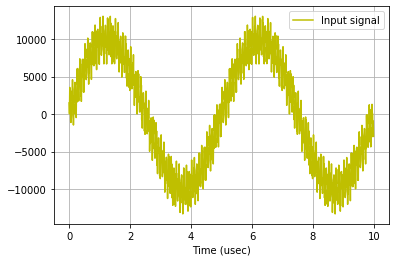

In [7]:
T = 0.002 # Gesamtzeit
fs = 100e6 # Abtastfrequenzh
n = int(T * fs) # Anzahl der Samples
t = np.linspace(0, T, n, endpoint=False) # Time vector in seconds
# Samples of the signal
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
samples = samples.astype(np.int32) # Wandle Samples um ins 32 Bit Integer Format:
print('Anzahl Samples: ', len(samples))
plot_to_notebook(t,samples,1000) # Plot signal to the notebook

## Software FIR Filter Implementierung mit Scipy's `lfilter`

Now we use the lfilter function from SciPy to filter the signal using our filter coefficients. The coefficients implement a low pass filter with passband 0-5MHz, and they were generated using this website: http://t-filter.engineerjs.com/

Ausführungszeit: 9.99451 ms


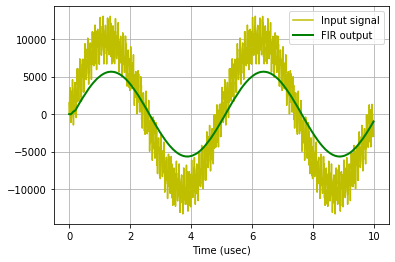

In [16]:
coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

start_time = time.time()
sw_fir_output = sig.lfilter(coeffs,70e3,samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Ausführungszeit: {0:g} ms'.format(sw_exec_time*1000))

plot_to_notebook(t,samples,1000,out_signal=sw_fir_output)

## Hardware FIR Implementierung

In den folgenden Codeblöcken testen wir die Hardware FIR Implementierung und messen die Performance.

In [17]:
from pynq import Overlay
import pynq.lib.dma

# Load the overlay
overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_accel.bit')

# Load the FIR DMA
dma = overlay.filter.fir_dma

ModuleNotFoundError: No module named 'pynq'

In [ ]:

from pynq import Xlnk

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time)
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)

# Plot to the notebook
plot_to_notebook(t,samples,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()

## Driver for FIR accelerator

To hide the details of the DMA from the programmer, and make the accelerator easier to use, we create a driver for it. Below is the driver that will be associated with the filter hierarchy that we created in Vivado, consisting of the FIR IP and the DMA.


In [ ]:
from pynq import DefaultHierarchy

class FirDriver(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description)

    def fir_filter(self, data):
        with xlnk.cma_array(shape=(len(data),), dtype=np.int32) as in_buffer,\
             xlnk.cma_array(shape=(len(data),), dtype=np.int32) as out_buffer:
            np.copyto(in_buffer,data)
            self.fir_dma.sendchannel.transfer(in_buffer)
            self.fir_dma.recvchannel.transfer(out_buffer)
            self.fir_dma.sendchannel.wait()
            self.fir_dma.recvchannel.wait()
            result = out_buffer.copy()
        return result

    @staticmethod
    def checkhierarchy(description):
        if 'fir' in description['ip'] \
           and 'fir_dma' in description['ip']:
            return True
        return False

We need to reload the overlay in order for the driver to be attached to the accelerator.

In [ ]:
from pynq import Overlay
import pynq.lib.dma

overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_accel.bit')

# Run the hardware FIR and measure the runtime
start_time = time.time()
result = overlay.filter.fir_filter(samples)
stop_time = time.time()
print('Hardware FIR execution time (with driver): ',stop_time-start_time)

# Plot to the notebook
plot_to_notebook(t,samples,1000,out_signal=out_buffer)